# Sequence Models & How to use them

**학습목표**
1. RNN, LSTM, GRU의 구조를 이해한다.
2. 위 모델을 사용하기 위한 데이터 구조를 이해한다.
3. 위 모든 내용을 코딩할 수 있다.

-----------------
* Thanks to : 한기영 대표님 @ Data Insight

## 1.환경 및 데이터 준비

### Import Packages

In [ ]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error



### Data Loading

In [ ]:
url = 'https://raw.githubusercontent.com/RayleighKim/Example_datasets/master/Stock_Edwards_Lifesciences_corporation.csv'

# 판다스로 데이터를 불러오시오.
data = pd.read_csv(url)
data.tail(10)

,Date,Open,High,Low,Close,Adj_Close,Volume
4382,2017/8/25,112.949997,113.400002,111.720001,111.760002,111.760002,1206400
4383,2017/8/28,112.559998,113.449997,112.470001,113.110001,113.110001,1050200
4384,2017/8/29,112.320000,113.250000,111.739998,111.830002,111.830002,1366000
4385,2017/8/30,112.019997,112.989998,111.529999,112.690002,112.690002,929200
4386,2017/8/31,112.820000,113.790001,112.440002,113.660004,113.660004,1091400
4387,2017/9/1,113.790001,114.099998,112.790001,113.309998,113.309998,950000
4388,2017/9/5,112.519997,113.529999,111.160004,111.870003,111.870003,1805200
4389,2017/9/6,112.029999,112.489998,110.250000,112.230003,112.230003,2136700
4390,2017/9/7,112.459999,112.900002,112.000000,112.339996,112.339996,1251600
4391,2017/9/8,112.300003,114.790001,112.010002,113.190002,113.190002,1611700


### !!! 2. 데이터 이해
### 탐색하기

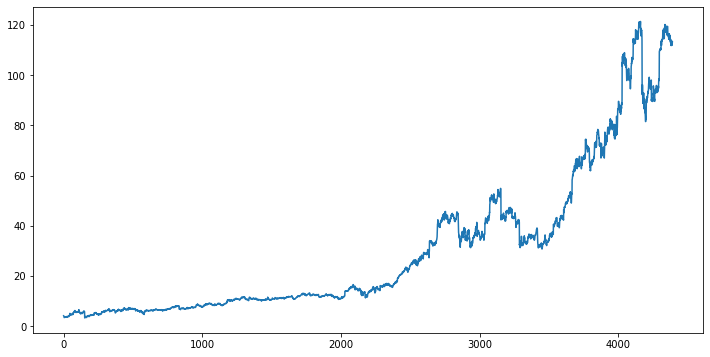

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.Close)
plt.show()

In [ ]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

##3.데이터 준비

### Date 컬럼을 제거하시오.

In [ ]:
data.drop('Date', axis = 1, inplace=True)

In [ ]:
data.tail()

,Open,High,Low,Close,Adj_Close,Volume
4387,113.790001,114.099998,112.790001,113.309998,113.309998,950000
4388,112.519997,113.529999,111.160004,111.870003,111.870003,1805200
4389,112.029999,112.489998,110.250000,112.230003,112.230003,2136700
4390,112.459999,112.900002,112.000000,112.339996,112.339996,1251600
4391,112.300003,114.790001,112.010002,113.190002,113.190002,1611700


## 4.Sequence 데이터 구조로 만들기

**조건**
* 내일의 Close를 예측할 것이다. 이를 Y로 둘 것.
* timestep은 4주를 본다. (주식은 5일이 1주일)
* 맞추어 전처리

**데이터 분할 규칙**
* 가장 최근 1주일을 테스트 데이터로 둔다.
* 테스트 데이터를 제외하고, 가장 최근 2주를 벨리데이션 데이터로 둔다.
********************* 2주 중 5일이 1주일이라 했으니 5*2 = 10 ****************

In [ ]:
# 판다스 데이터 프레임을 넘파이로 옮김.
data = data.values # df의 값을 np array로 넘긴다.

In [ ]:
data.shape

(4392, 6)

In [ ]:
# close 컬럼의 위치를 주의해 주세요.
# 너무 어렵다면, 앞전 실습의 코드를 가져다가 '수정'해보는 전략으로 진행하는 것도 좋습니다.

# 여기에 의미있는 기간(timestep을 지정해 봅시다.)
timestep = 20 # 한 번에 20주씩 고려하자.

# x의 데이터 구조를 3차원으로 만들어 줘야 함
x = np.array([data[i : i + timestep] for i in range( len(data) - timestep) ])
y = np.array([data[i + timestep, -1] for i in range( len(data) - timestep) ])

x_train, x_val, x_test = x[:-15], x[-15:-5], x[-5:]
y_train, y_val, y_test = y[:-15], y[-15:-5], y[-5:]

## 모양 확인 필수
print(x.shape, y.shape)
print('-------------------------------')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)
print('-------------------------------')
print('[ # , timestep, feature수 ] <-- 데이터의 구조 : ')


(4372, 20, 6) (4372,)
-------------------------------
(4357, 20, 6) (4357,)
(10, 20, 6) (10,)
(5, 20, 6) (5,)
-------------------------------
[ # , timestep, feature수 ] <-- 데이터의 구조 : 


데이터의 구조 : [n, timestep, feature수]

# Q.1. 단순 RNN복습

1. 적절한 인풋 레이어를 구성할 것
2. 첫번째 히든레이어 : SimpleRNN
    * 히든스테이트 노드 16개, return_sequences=True
3. 두번째 히든레이어 : SimpleRNN
    * 히든스테이트 노드 32개, return_sequences=True
4. 플래튼
5. 회귀를 위한 적절한 아웃풋 레이어

![image.png](attachment:image.png)

In [ ]:
x_train.shape, y_train.shape

((4357, 20, 6), (4357,))

In [ ]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten

In [ ]:
####################
## Your Code Here ##
####################
# 1. 세션클리어
keras.backend.clear_session()

# 2. Sequential 모델 선언하기
model = keras.models.Sequential(name='my_first_rnn')

# 3. 모델 구조 짜기
# 적절한 인풋 레이어를 구성할 것
# model.add(Input(shape = ( 한꺼번에 관찰할 시점 수, 시점별 feature 개수 )))
model.add(Input(shape = ( 20, 6), name = 'input_layer'))
# 첫번째 히든레이어 : SimpleRNN 히든스테이트 노드 16개, return_sequences = True
model.add(SimpleRNN( 16, activation = 'tanh', return_sequences = True, name = 'hidden1_rnn' ))
# 두번째 히든레이어 : SimpleRNN 히든스테이트 노드  32개, return_sequences = True
model.add(SimpleRNN( 32, activation = 'tanh', return_sequences = True, name = 'hidden2_rnn' ))
# 플래튼
model.add(Flatten(name = 'hidden3_flatten'))
# 회귀를 위한 적절한 아웃풋 레이어
model.add(Dense(1))
# 4. 모델 컴파일
model.compile(loss = 'mse', optimizer = 'adam') # 'mae'는 'mse' 대비 급격한 학습을 막는데 종종 사용이 된다.

# (옵션). 모델 요약
model.summary()

Model: "my_first_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1_rnn (SimpleRNN)     (None, 20, 16)            368       
                                                                 
 hidden2_rnn (SimpleRNN)     (None, 20, 32)            1568      
                                                                 
 hidden3_flatten (Flatten)   (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 641       
                                                                 
Total params: 2,577
Trainable params: 2,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습 과정에서 ValueError: Input 0 of layer "my_first_rnn" is incompatible with the layer: expected shape=(None, 21, 1), found shape=(None, 20, 6) 에러 해결하기 위해 작성
x_train.shape, y_train.shape

((4357, 20, 6), (4357,))

In [ ]:
## 학습도 시킬 것
hist = model.fit(x_train, y_train, epochs = 100, validation_data = (x_val, y_val), verbose = 1)


Epoch 1/100
137/137 [==============================] - 7s 14ms/step - loss: 6004537819136.0000 - val_loss: 1691660058624.0000
Epoch 2/100
137/137 [==============================] - 1s 10ms/step - loss: 6004174487552.0000 - val_loss: 1691423997952.0000
Epoch 3/100
137/137 [==============================] - 1s 11ms/step - loss: 6003832651776.0000 - val_loss: 1691195146240.0000
Epoch 4/100
137/137 [==============================] - 1s 10ms/step - loss: 6003495534592.0000 - val_loss: 1690969047040.0000
Epoch 5/100
137/137 [==============================] - 2s 12ms/step - loss: 6003167330304.0000 - val_loss: 1690745831424.0000
Epoch 6/100
137/137 [==============================] - 2s 17ms/step - loss: 6002838077440.0000 - val_loss: 1690523664384.0000
Epoch 7/100
137/137 [==============================] - 2s 12ms/step - loss: 6002505678848.0000 - val_loss: 1690300973056.0000
Epoch 8/100
137/137 [==============================] - 1s 11ms/step - loss: 6002180096000.0000 - val_loss: 16900798545

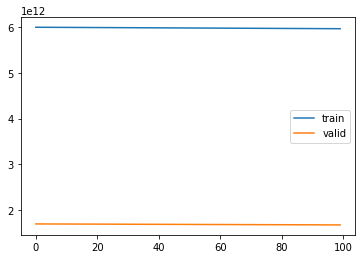

In [ ]:
# 학습 곡선을 그린다
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

In [ ]:
# Q1. 테스트 셋에서의 RMSE를 출력하여라.
from sklearn.metrics import mean_squared_error as MSE

y_pred = model.predict(x_test)
MSE(y_test, y_pred) ** 0.5


1/1 [==============================] - 0s 298ms/step


1597256.4758148897

In [ ]:
model.summary()

Model: "my_first_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1_rnn (SimpleRNN)     (None, 20, 16)            368       
                                                                 
 hidden2_rnn (SimpleRNN)     (None, 20, 32)            1568      
                                                                 
 hidden3_flatten (Flatten)   (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 641       
                                                                 
Total params: 2,577
Trainable params: 2,577
Non-trainable params: 0
_________________________________________________________________


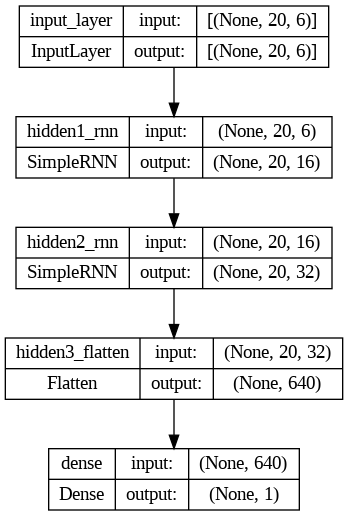

In [ ]:
plot_model(model, show_shapes = True)

# Q.2. LSTM, GRU 복습

1. 적절한 인풋 레이어를 구성할 것
2. 첫번째 히든레이어 : LSTM
    * 히든스테이트 노드 16개, return_sequences=True
3. 두번째 히든레이어 : GRU
    * 히든스테이트 노드 32개, return_sequences=True
4. 플래튼
5. Fully Connected Layer, 노드 128개, swish
- swish는 relu와 비슷하거나 조금 나은 건데 activation으로 한 번 써보세요 
5. 회귀를 위한 적절한 아웃풋 레이어

In [ ]:
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.models import Model

In [ ]:
####################
## Your Code Here ##
####################
# 1. 세션클리어
keras.backend.clear_session()

# 2. 모델 사슬처럼 엮기 - 초반에는 무엇이 어디로 엮이는지 다 알 수 있게 작성해 주는 게 좋다.
il = Input( shape = (20, 6) )
hl1 = LSTM(16, return_sequences = True)(il)
hl2 = GRU(32, return_sequences = True)(hl1)
hl3 = Flatten()(hl2)
ol = Dense(1)(hl3)

# 3. 모델 처음과 끝 지정
model = Model(il, ol)

# 4. 모델 컴파일
model.compile(loss = 'mae', optimizer = 'adam') # 'mae'는 'mse' 대비 급격한 학습을 막는데 종종 사용이 된다.

# (옵션). 모델 요약
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 16)            1472      
                                                                 
 gru (GRU)                   (None, 20, 32)            4800      
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 641       
                                                                 
Total params: 6,913
Trainable params: 6,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## 학습도 시킬 것
hist = model.fit(x_train, y_train, epochs = 100, validation_data = (x_val, y_val), verbose = 1)


Epoch 1/100
137/137 [==============================] - 9s 29ms/step - loss: 1867829.7500 - val_loss: 1264233.5000
Epoch 2/100
137/137 [==============================] - 3s 22ms/step - loss: 1867721.2500 - val_loss: 1264133.7500
Epoch 3/100
137/137 [==============================] - 4s 27ms/step - loss: 1867623.5000 - val_loss: 1264037.8750
Epoch 4/100
137/137 [==============================] - 3s 24ms/step - loss: 1867528.6250 - val_loss: 1263943.8750
Epoch 5/100
137/137 [==============================] - 3s 22ms/step - loss: 1867435.5000 - val_loss: 1263851.5000
Epoch 6/100
137/137 [==============================] - 3s 23ms/step - loss: 1867343.7500 - val_loss: 1263760.3750
Epoch 7/100
137/137 [==============================] - 4s 29ms/step - loss: 1867253.5000 - val_loss: 1263669.8750
Epoch 8/100
137/137 [==============================] - 3s 23ms/step - loss: 1867162.7500 - val_loss: 1263580.1250
Epoch 9/100
137/137 [==============================] - 3s 23ms/step - loss: 1867073.7500

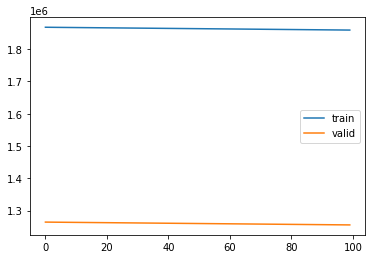

In [ ]:
# 학습 곡선을 그린다
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

In [ ]:
# Q1. 테스트 셋에서의 RMSE를 출력하여라.
y_pred = model.predict(x_test)
MSE(y_test, y_pred) ** 0.5


1/1 [==============================] - 0s 33ms/step


1597117.5580002395

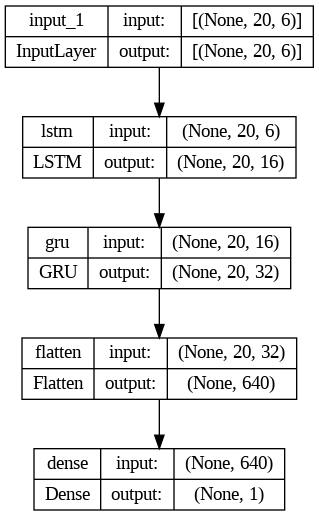

In [ ]:
plot_model(model, show_shapes = True)

# 실습?

In [ ]:
x_train.shape, y_train.shape

((4357, 20, 6), (4357,))

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN
from tensorflow.keras.layers import Input, LSTM, GRU # 오전까지 배운 것
from tensorflow.keras.layers import Bidirectional, Conv1D, MaxPool1D # 오후에 배운 것

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.backend import clear_session


In [40]:
clear_session()

il = Input(shape = (20, 6)) # 한번에 20 시점, 시점당 6개 feature 존재

hl = Conv1D(filters = 16,  # 16 종류의 특징을 제작해 줘
            kernel_size = 5, # 한 번에 5시점씩 봐줘야 해. 일주일씩 보고 싶어서 커널사이즈 5
            activation = 'relu',
            padding='same')(il)
hl = Conv1D(filters = 16,  # 16 종류의 특징을 제작해 줘
            kernel_size = 5, # 한 번에 5시점씩 봐줘야 해. 일주일씩 보고 싶어서 커널사이즈 5
            activation = 'relu',
            padding='same')(hl)
hl = MaxPool1D(2)(hl) # 배치놈과 드롭아웃은 시퀀스 데이터 <-- 생각해 볼 주제

hl = Bidirectional(layer = LSTM(32, return_sequences=True))(hl)

forward_gru = GRU(32, return_sequences=True)
backward_LSTM = LSTM(24, return_sequences=True, go_backwards=True) # 너는 지금부터 역행을 해야 되는 아이란다 >> go_backwards 트루
hl = Bidirectional( layer = forward_gru, backward_layer=backward_LSTM )(hl) # 백월드 레이어의 인풋이 있으면 일반 레이어는 포워드 레이어로만 동작합니다.

hl = Flatten()(hl) 
ol = Dense(1, activation='relu')(hl) # 무슨 효과가 있을까요?, 아웃풋레이어에서 음수 안 나오게 할 수 있지 않나요? 어차피 0 이하는 안 나와야 하는 데이터, 제약을 걸기!

model = Model(il, ol)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 20, 16)            496       
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 16)            1296      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 16)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 10, 64)           12544     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 56)           17952 